# Self-Driving Car Engineer Nanodegree

## Project: Traffic Sign Recognition Classifier

Import Packages
---

In [192]:
import tensorflow as tf
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from sklearn.utils import shuffle
from io import StringIO
import cv2
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.image as mpimg
%matplotlib inline

Load Data from pickle files
---

In [193]:
train_file = 'traffic-signs-data/train.p'
valid_file = 'traffic-signs-data/valid.p'
test_file = 'traffic-signs-data/test.p'

with open(train_file, 'rb') as f:
    train_data = pickle.load(f)
    f.close()
    
with open(valid_file, 'rb') as f:
    valid_data = pickle.load(f)
    f.close()
    
with open(test_file, 'rb') as f:
    test_data = pickle.load(f)
    f.close()
    
X_train, y_train = train_data['features'], train_data['labels']
X_valid, y_valid = valid_data['features'], valid_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

Map csv file to label numbers
---

In [194]:
y_labels = pd.read_csv('signnames.csv')
print (y_labels['SignName'][3])

Speed limit (60km/h)


Summarize the data
---

In [195]:
assert len(X_train) == len(y_train), 'Training feature and label set length not matching'
assert len(X_valid) == len(y_valid), 'Validation feature and label set length not matching'
assert len(X_test) == len(y_test), 'Testing feature and label set length not matching'

n_train = X_train.shape[0]
n_valid = X_valid.shape[0]
n_test = X_test.shape[0]

print ('Number of training examples: ', n_train)
print ('Number of validation examples: ', n_valid)
print ('Number of testing examples: ', n_test)

n_classes = len(set(y_train))
print ('Number of classes: ', n_classes)

image_shape = X_train[0].shape
print ('Image shape: ', image_shape)

Number of training examples:  34799
Number of validation examples:  4410
Number of testing examples:  12630
Number of classes:  43
Image shape:  (32, 32, 3)


Exploratory visualization of the data
---

Displaying a random image with it's corresponding label
22  <==>  Bumpy road


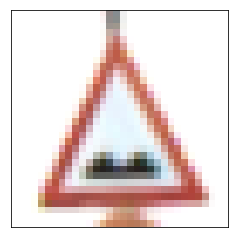

---------------------------------------------------------------------------------------------------------------


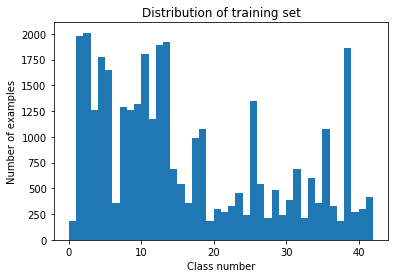

Stats of training set
Maximum distribution is for label 2 (Speed limit (50km/h)) with 2010 examples
Minimum distribution is for label 0 (Speed limit (20km/h)) 19 (Dangerous curve to the left) 37 (Go straight or left) with 180 examples
----------------------------------------------------------------------------------------------------------------


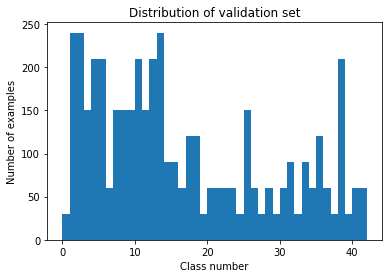

Stats of validation set
Maximum distribution is for label 1 (Speed limit (30km/h)) 2 (Speed limit (50km/h)) 13 (Yield) with 240 examples
Minimum distribution is for label 0 (Speed limit (20km/h)) 19 (Dangerous curve to the left) 24 (Road narrows on the right) 27 (Pedestrians) 29 (Bicycles crossing) 32 (End of all speed and passing limits) 37 (Go straight or left) 39 (Keep left) with 30 examples


In [196]:
index = random.randint(0, len(X_train))
image = X_train[index]

print ('Displaying a random image with it\'s corresponding label')
print(y_train[index],' <==> ',y_labels['SignName'][y_train[index]])
plt.figure()
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.show()
print ('---------------------------------------------------------------------------------------------------------------')
n = np.arange(0, n_classes, 1)
plt.figure()
y, x, _ = plt.hist(y_train, n)
plt.xlabel('Class number')
plt.ylabel('Number of examples')
plt.title('Distribution of training set')
plt.savefig('Training Set')
plt.show()
x_max = np.where(y == y.max())
x_min = np.where(y == y.min())
print ('Stats of training set')
print ('Maximum distribution is for label ', end='')
for i in range(len(np.where(y == y.max())[0])):
    print ('{} ({}) '.format( x[x_max][i], y_labels['SignName'][x[x_max][i]]), end='')
print ('with {} examples'.format(int(y.max())))
print ('Minimum distribution is for label ', end='')
for i in range(len(np.where(y == y.min())[0])):
    print('{} ({}) '.format( x[x_min][i], y_labels['SignName'][x[x_min][i]]), end='')
print ('with {} examples'.format(int(y.min())))
print ('----------------------------------------------------------------------------------------------------------------')
n = np.arange(0, n_classes, 1)
plt.figure()
y, x, _ = plt.hist(y_valid, n)
plt.xlabel('Class number')
plt.ylabel('Number of examples')
plt.title('Distribution of validation set')
plt.savefig('Validation Set')
plt.show()
x_max = np.where(y == y.max())
x_min = np.where(y == y.min())
print ('Stats of validation set')
print ('Maximum distribution is for label ', end='')
for i in range(len(np.where(y == y.max())[0])):
    print ('{} ({}) '.format( x[x_max][i], y_labels['SignName'][x[x_max][i]]), end='')
print ('with {} examples'.format(int(y.max())))
print ('Minimum distribution is for label ', end='')
for i in range(len(np.where(y == y.min())[0])):
    print('{} ({}) '.format( x[x_min][i], y_labels['SignName'][x[x_min][i]]), end='')
print ('with {} examples'.format(int(y.min())))

Data Preprocessing
---

In [209]:
def Preprocessing(X, mean_train = 0, stddev_train = 0, training = 0):
    """
        Preprocess the images. Preprocessed = (input - mean of the train)/(std. deviation of the train)
        X: Input images
        mean_train: Mean of the training set of the images. 0 if training set.
        stddev_train: Std. deviation of the training set of the images. 0 if training set.
        training: Flag to indicate if it is training. 1 if training set, 0 otherwise
        Returns preprocessed image
    """
    if training == 1:
        plt.imsave('stats/original_image.png', X[500])
        mean_train = np.mean(X, axis = 0)
        stddev_train = np.std(X, axis = 0)
        X = (X - mean_train)
        cv2.imwrite('stats/Zero-centered.png', X[500])
        X = X / (stddev_train + 1e-5)
        return X, mean_train, stddev_train
    else:
        X = (X - mean_train)/(stddev_train + 1e-5)
        return X


pre_train, mean_train, stddev_train = Preprocessing(X_train, training = 1)
pre_valid = Preprocessing(X_valid, mean_train, stddev_train)

Network helper functions
---

In [198]:
def Convolution(data, w, b, stride = 1, padding = 'VALID'):
    """
        Convolution layer of the network
        data: input data to the layer
        w: Weight variable of this layer
        b: Bias variable of this layer
        stride: Default 1
        padding: Default VALID padding
    """
    return tf.nn.bias_add(tf.nn.conv2d(data, w, strides=[1, stride, stride, 1], padding=padding), b)

def Max_Pool(data, kSize = 2, stride = 2, padding = 'VALID'):
    """
        Max Pool layer of the network
        data: input data to the layer
        kSize: Kernel-size, default to 2
        stride: Default 2
        padding: Default VALID padding
    """
    return tf.nn.max_pool(data, [1, kSize, kSize, 1], [1, stride, stride, 1], padding)

def Avg_Pool(data, kSize = 2, stride = 2, padding = 'VALID'):
    """
        Avg Pool layer of the network
        data: input data to the layer
        kSize: Kernel size, default to 2
        stride: Default 2
        padding: Default VALID padding
    """
    return tf.nn.avg_pool(data, [1, kSize, kSize, 1], [1, stride, stride, 1], padding)

def ReLU(data):
    """
        ReLU layer of the network
        data: input data to the layer
    """
    return tf.nn.relu(data)

def FullyConnected(data, w, b):
    """
        Fully connected layer
        data: input data to the layer
        w: weight variable of the layer
        b: bias variable of the layer
    """
    return tf.add(tf.matmul(data, w), b)

def Dropout(data, keep_prob):
    """
        Dropout layer of the network
        data: input data to the layer
        keep_prob: Probability to keep the data
    """
    return tf.nn.dropout(data, keep_prob)

def InitializeWeights(size, mean, stddev):
    """
        Function to initialize weights
        size: Shape of the weight variable of the layer
        mean: Initial mean of the layer
        stddev: Initial standard deviation of the layer
    """
    return tf.Variable(tf.truncated_normal(size, mean=mean, stddev=stddev))

def InitializeBias(size):
    """
        Function to initialize bias
        size: Shape of the bias variable of the layer
    """
    return tf.Variable(tf.zeros(size))

def Flatten(data):
    """
        Flatten the data to the 1-D
        data: input data of the layer
    """
    return tf.contrib.layers.flatten(data)

Model
---

In [199]:
def model(input_data, n_classes, architecture):
    """
        Function defining the network architecture
        input_data: input data to the network
        n_classes: Number of output classes
        architecture: choose between 2 architectures, can take either 1 or 2
        Returns logits
    """
    mu = 0
    sigma = 0.1
    
    if architecture == 1:
        w = InitializeWeights([5, 5, 3, 6], mu, sigma)
        b = InitializeBias(6)
        logits = Convolution(input_data, w, b)
        
        logits = ReLU(logits)
        
        logits = Max_Pool(logits)
        
        w = InitializeWeights([5, 5, 6, 16], mu, sigma)
        b = InitializeBias(16)
        logits = Convolution(logits, w, b)
        
        logits = ReLU(logits)
        
        logits = Max_Pool(logits)
        
        logits = Flatten(logits)
        
        w = InitializeWeights([400, 120], mu, sigma)
        b = InitializeBias(120)
        logits = FullyConnected(logits, w, b)
        
        logits = ReLU(logits)
        
        w = InitializeWeights([120, 84], mu, sigma)
        b = InitializeBias(84)
        logits = FullyConnected(logits, w, b)
        
        logits = ReLU(logits)
        
        w = InitializeWeights([84, n_classes], mu, sigma)
        b = InitializeBias(n_classes)
        logits = FullyConnected(logits, w, b)
        
        return logits
        
    elif architecture == 2:
        
        # input = [None, 32, 32, 1], output = [None, 28, 28, 6]
        w1 = InitializeWeights([5, 5, 3, 6], mu, sigma)
        b1 = InitializeBias(6)
        conv1 = Convolution(input_data, w1, b1, 1, 'VALID')
        
        # no change in dimension
        relu1 = ReLU(conv1)
        
        # input = [None, 28, 28, 6], output = [None, 24, 24, 16]
        w2 = InitializeWeights([5, 5, 6, 16], mu, sigma)
        b2 = InitializeBias(16)
        conv2 = Convolution(relu1, w2, b2, 1, 'VALID')
        
        # no change in dimension
        relu2 = ReLU(conv2)

        # input = [None, 24, 24, :], output = [None, 12, 12, :]
        pool1 = Max_Pool(relu2)

        # input = [None, 12, 12, 16], output = [None, 8, 8, 32]
        w3 = InitializeWeights([5, 5, 16, 32], mu, sigma)
        b3 = InitializeBias(32)
        conv3 = Convolution(pool1, w3, b3, 1, 'VALID')

        # no change in dimension
        relu3 = ReLU(conv3)

        # input = [None, 8, 8, 32], output = [None, 4, 4, 64]
        w4 = InitializeWeights([5, 5, 32, 64], mu, sigma)
        b4 = InitializeBias(64)
        conv4 = Convolution(relu3, w4, b4, 1, 'VALID')

        # no change in dimension
        relu4 = ReLU(conv4)

        # input = [None, 4, 4, :], output = [None, 2, 2, :]
        pool2 = Max_Pool(relu4)

        # Flatten data
        fc0 = tf.contrib.layers.flatten(pool2)

        # Fully connected, input = [None, 256], output = [None, 128]
        w5 = InitializeWeights([256, 128], mu, sigma)
        b5 = InitializeBias(128)
        fc1 = FullyConnected(fc0, w5, b5)

        # no change in dimesion
        relu5 = ReLU(fc1)

        # Fully connected, input = [None, 128], output = [None, 64]
        w6 = InitializeWeights([128, 64], mu, sigma)
        b6 = InitializeBias(64)
        fc2 = FullyConnected(relu5, w6, b6)

        # no change in dimesion
        relu6 = ReLU(fc2)

        dr1 = Dropout(relu6, keep_prob)

        # Fully connected, input = [None, 64], output = [None, n_classes]
        w7 = InitializeWeights([64, n_classes], mu, sigma)
        b7 = InitializeBias(n_classes)
        logits = FullyConnected(dr1, w7, b7)

        return logits, [conv1, relu1, conv2, relu2, pool1, conv3, relu3, conv4, relu4, pool2]

In [200]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

def top_k(X_data, y_data):
    num_examples = len(X_data)
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        values,indices = sess.run([top5_operation[0], top5_operation[1]], feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        return values, indices

x = tf.placeholder(tf.float32, (None, image_shape[0], image_shape[1], 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)


rate = 0.01

logits, weights = model(x, n_classes, 2)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.GradientDescentOptimizer(rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
top5_operation = tf.nn.top_k(tf.nn.softmax(logits), 5)
saver = tf.train.Saver()


EPOCHS = 30
BATCH_SIZE = 128

In [201]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(pre_train)
    loss_vector = []

    print("Training...")
    print()
    for i in range(EPOCHS):
        count = 0
        loss_sum = 0
        training_acc_sum = 0
        pre_train, y_train = shuffle(pre_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = pre_train[offset:end], y_train[offset:end]
            _, loss, training_accuracy = sess.run([training_operation, loss_operation, accuracy_operation],feed_dict={x: batch_x, y: batch_y, keep_prob:0.5})
            loss_sum += loss
            count = count + 1
            training_acc_sum += training_accuracy
        validation_accuracy = evaluate(pre_valid, y_valid)
        avg_loss = loss_sum / count
        avg_training_acc = training_acc_sum/count
        loss_vector.append([i, avg_loss, validation_accuracy, avg_training_acc])        
        print("EPOCH {} ...".format(i+1))
        print ('Loss = {:.3f}'.format(avg_loss))
        print("Training Accuracy = {:.3f}".format(avg_training_acc))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver.save(sess, './tsc')
    sess.close()
    print("Model saved")

Training...

EPOCH 1 ...
Loss = 3.245
Training Accuracy = 0.160
Validation Accuracy = 0.360

EPOCH 2 ...
Loss = 2.122
Training Accuracy = 0.418
Validation Accuracy = 0.590

EPOCH 3 ...
Loss = 1.419
Training Accuracy = 0.579
Validation Accuracy = 0.732

EPOCH 4 ...
Loss = 1.036
Training Accuracy = 0.680
Validation Accuracy = 0.813

EPOCH 5 ...
Loss = 0.820
Training Accuracy = 0.742
Validation Accuracy = 0.840

EPOCH 6 ...
Loss = 0.684
Training Accuracy = 0.784
Validation Accuracy = 0.870

EPOCH 7 ...
Loss = 0.586
Training Accuracy = 0.815
Validation Accuracy = 0.868

EPOCH 8 ...
Loss = 0.508
Training Accuracy = 0.838
Validation Accuracy = 0.900

EPOCH 9 ...
Loss = 0.455
Training Accuracy = 0.854
Validation Accuracy = 0.890

EPOCH 10 ...
Loss = 0.421
Training Accuracy = 0.867
Validation Accuracy = 0.912

EPOCH 11 ...
Loss = 0.381
Training Accuracy = 0.878
Validation Accuracy = 0.926

EPOCH 12 ...
Loss = 0.345
Training Accuracy = 0.890
Validation Accuracy = 0.925

EPOCH 13 ...
Loss = 0.31

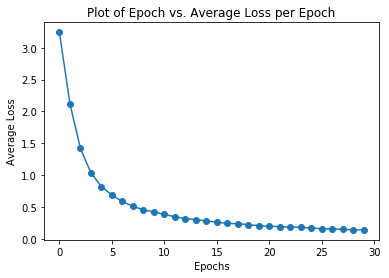

In [212]:
c = [loss_vector[i][0] for i in range(len(loss_vector))]
l = [loss_vector[i][1] for i in range(len(loss_vector))]
plt.plot(c, l, '-o', label='Average Loss')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('Plot of Epoch vs. Average Loss per Epoch')
plt.show()

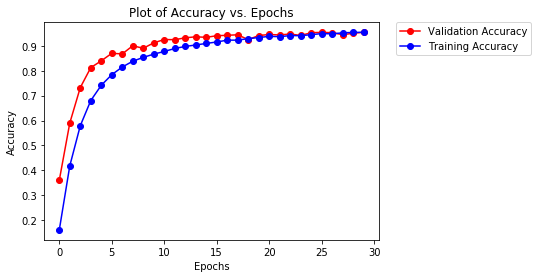

In [213]:
v = [loss_vector[i][2] for i in range(len(loss_vector))]
t = [loss_vector[i][3] for i in range(len(loss_vector))]
c = [loss_vector[i][0] for i in range(len(loss_vector))]
plt.plot(c, v, '-or', label='Validation Accuracy')
plt.plot(c, t, '-ob', label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Plot of Accuracy vs. Epochs')
plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.)
plt.show()

Restore the trained model
---

In [214]:
with tf.Session() as sess:
    saver.restore(sess, './tsc')
    pre_test = Preprocessing(X_test, mean_train, stddev_train)
    test_accuracy = evaluate(pre_test, y_test)
    print ('Testing accuracy = {:.3f}'.format(test_accuracy))
    
    test_set = []
    test_images = ['test_images/priority.jpg',  
                   'test_images/yield.jpg', 
                   'test_images/german-road-signs-pedestrians.png', 
                   'test_images/no-overtaking-sign.png',
                   'test_images/traffic_signal_ahead.png',
                   'test_images/children_crossing.jpg',
                  'test_images/70kmph.jpg',
                  'test_images/stop.jpg',
                  'test_images/keep_right.png',
                  'test_images/yield_2.jpg']
    test_labels = np.array([12, 13, 27, 9, 26, 28, 4, 14, 38, 13])
    for img_file in test_images:
        img = cv2.imread(img_file)
        if img.shape[2] == 4:
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (32,32))
        test_set.append(img)
    test_set = np.asarray(test_set)
    pre_test1 = Preprocessing(test_set, mean_train, stddev_train)
    test1_accuracy = evaluate(pre_test1, test_labels)
    print ('Testing accuracy = {:.3f}'.format(test1_accuracy))
    values, indices = top_k(pre_test1, test_labels)
    for i in range(len(test_labels)):
        print ('\nOriginal label: {}\t{}\nTop 5 candidates are:'.format(test_labels[i], y_labels['SignName'][test_labels[i]]))
        for j in range(len(values[0])):
            print ('{}.\t{:.3f}\t{}\t{}'.format(j+1, values[i][j], indices[i][j], y_labels['SignName'][indices[i][j]]))
    sess.close()

INFO:tensorflow:Restoring parameters from ./tsc
Testing accuracy = 0.934
Testing accuracy = 0.700

Original label: 12	Priority road
Top 5 candidates are:
1.	1.000	12	Priority road
2.	0.000	15	No vehicles
3.	0.000	26	Traffic signals
4.	0.000	13	Yield
5.	0.000	29	Bicycles crossing

Original label: 13	Yield
Top 5 candidates are:
1.	0.958	36	Go straight or right
2.	0.027	12	Priority road
3.	0.010	26	Traffic signals
4.	0.005	35	Ahead only
5.	0.000	33	Turn right ahead

Original label: 27	Pedestrians
Top 5 candidates are:
1.	0.834	27	Pedestrians
2.	0.095	18	General caution
3.	0.071	11	Right-of-way at the next intersection
4.	0.000	30	Beware of ice/snow
5.	0.000	24	Road narrows on the right

Original label: 9	No passing
Top 5 candidates are:
1.	1.000	9	No passing
2.	0.000	10	No passing for vehicles over 3.5 metric tons
3.	0.000	26	Traffic signals
4.	0.000	20	Dangerous curve to the right
5.	0.000	16	Vehicles over 3.5 metric tons prohibited

Original label: 26	Traffic signals
Top 5 candidates ar

INFO:tensorflow:Restoring parameters from ./tsc
After Conv1


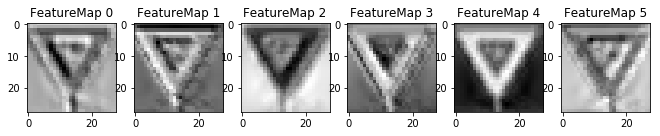

After ReLU1


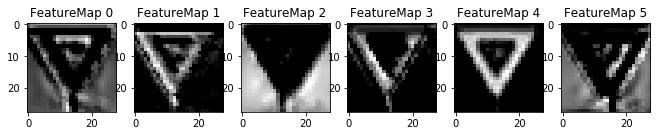

After Conv2


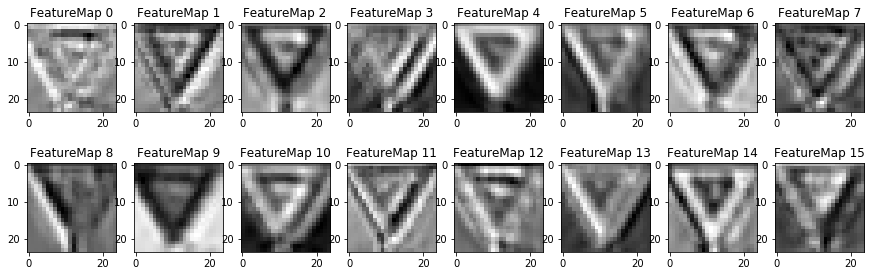

After ReLU2


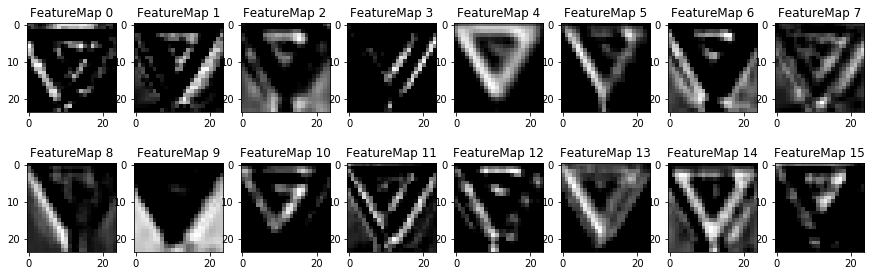

After Pool1


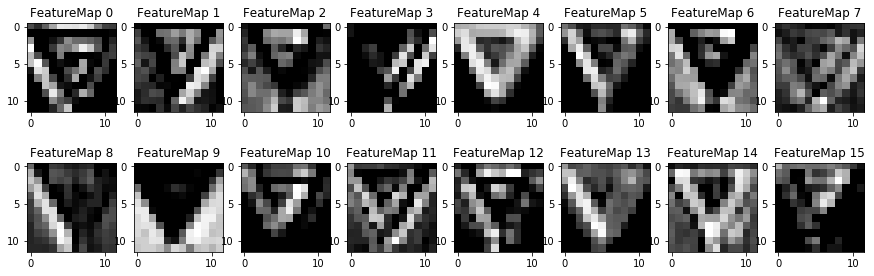

In [211]:
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
    plt.show()
            
with tf.Session() as sess:
    saver.restore(sess, './tsc')
    display_test = np.zeros([1, 32, 32, 3])
    display_test[0, :, :, :] = pre_test1[9]
    print ('After Conv1')
    outputFeatureMap(display_test, weights[0])
    print ('After ReLU1')
    outputFeatureMap(display_test, weights[1])
    print ('After Conv2')
    outputFeatureMap(display_test, weights[2])
    print ('After ReLU2')
    outputFeatureMap(display_test, weights[3])
    print ('After Pool1')
    outputFeatureMap(display_test, weights[4])